# **Processing of Clapping Motion Data Collected from Chest-Mounted Accelerometers at MusicLab Copenhagen Concert**

> Ahmet Emin Memis
> ahmeteminmemis@gmail.com
> 07.02.2022

Adjusted to process data as prepared for public release, with corrected alignment information and additional sensors. Finn Upham 20220415



During the MusicLab concert, audience members placed mobile phones on their chests which allowed us to collect their motion data while they are experiencing the concert. Some audience members without usable phones were lent accelerometer sensors (AX3).

Throuhout the concert, 15 clappings occurred either after speeches or musical pieces or at the end of the concert. This notebook processes the motion data of 85 participants during these clapping sections.

# Dependencies

In [21]:
# dependencies

import os
import math
import scipy
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt

pd.options.mode.chained_assignment = None

In [22]:
# functions

def rms_signal(data, window_size, shift):
  # data is pandas Series of signal
  # function to calculate root mean square using a scrolling window.
  i = int(window_size/2)
  l = data.shape[0]
  rms_y = [np.nan]*l

  while True:
    if i >= l:
      break

    if (i >= window_size/2) and (l-i >= window_size/2):
      in_window  = int(i-window_size/2)
      out_window = int(i+window_size/2)

      data_rms = data.iloc[in_window:out_window]
      if data_rms.isna().sum() < (len(data_rms)):
        data_rms = data_rms.dropna()
      rms_value = math.sqrt(sum([i*i for i in data_rms])/len(data_rms)) if data_rms.isna().sum() == 0 else -1

    else:
      rms_value = np.nan

    rms_y[i] = rms_value
    i = i + shift

  df = pd.DataFrame(index = data.index, columns = ['rms'], data={'rms': rms_y})
  return df

def butter_lowpass_filter(data, cutoff, fs, order):
  normal_cutoff = cutoff / nyq
  b, a = butter(order, normal_cutoff, btype='low', analog=False)
  y = filtfilt(b, a, data)
  return y


# NEW NO PD APPEND
def gap_nans(data,gap_t):
    # data is a pandas dataframe with columns called time and/or time_concert which is used to ID gaps greater than gap_T
    # gap_T is in milliseconds (ms)
    # rows of NaN data is added to non-time columns before the first sample, at edges of each gap, and after the last sample of data
    # these nans prevent interpolation errors through missing data
    cols = data.columns
    if 'time' in cols:
        time_col = 'time'
    if 'time_concert' in cols:
        time_col = 'time_concert'
        
    deltat = round(0.35*data[time_col].diff().median())
    dtdeltat =  pd.to_timedelta(deltat,unit = 'ms')
    dt = data[time_col].diff()    
    gapsi = np.array(dt[dt>gap_t].index)
    a = np.append(gapsi-1,dt.index[-1])
    gapsd = pd.DataFrame(index = a,columns = data.columns)
    for c in cols:
        if c.startswith('datetime'):
            gapsd[c] = data.loc[a,c]+dtdeltat
        if c.startswith('time'):
            gapsd[c] = data.loc[a,c]+deltat 

    a = np.append(gapsi,dt.index[0])
    gapsp = pd.DataFrame(index = a,columns = data.columns)
    for c in cols:
        if c.startswith('datetime'):
            gapsp[c] = data.loc[a,c]-dtdeltat
        if c.startswith('time'):
            gapsp[c] = data.loc[a,c]-deltat 

    data = pd.concat([gapsp,gapsd,data]).sort_values(time_col,ignore_index=True)
    return data

In [225]:
SAMPLE_RATE = 50
EXTEND_WINDOW = {1:5, 2:5, 3:5, 4:5}
DIR = 'C:/Users/finnu/dev/copenhagen-musiclab-clapping/clapfiles' #windows path to output data

In [226]:
general_loc = 'C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/'

public_mlmotion = general_loc + 'Public/Motion_ML/'
public_ax3 = general_loc +  'Public/Motion_AX3/'
public_Part = general_loc + 'Public/Participants/'
public_time = general_loc + 'Public/Timing/'

In [227]:
# set the sampling period for the concert in UTC 
Start_time = pd.to_datetime('2021-10-26 17:30:00+0000').replace(tzinfo=None)
Synch_time = pd.to_datetime('2021-10-26 17:48:06+0000').replace(tzinfo=None)
Mid_time = pd.to_datetime('2021-10-26 19:00:00+0000').replace(tzinfo=None)
End_time = pd.to_datetime('2021-10-26 20:30:00+0000').replace(tzinfo=None)

# concert times 50 Hz
ts_ct = np.arange(-1086,9715, 0.02)*1000 
dt_ct = Synch_time + pd.to_timedelta(ts_ct,unit='ms')


concert_times = pd.read_csv(public_time +'Concert_Events_On_Off.csv',sep=",") #SV alignment for beeps
concert_times['sequence'] = concert_times.index
concert_times.set_index('Time_dt_Start',inplace = True)
concert_times.iloc[:5]

Event  Time_s_Start  Time_ms_Start  \
Time_dt_Start                                                       
2021-10-26 17:36:32.760      Claps 1       -693.24      -693240.0   
2021-10-26 17:36:50.820  MC Speach 1       -675.18      -675180.0   
2021-10-26 17:38:47.960      Claps 2       -558.04      -558040.0   
2021-10-26 17:38:53.840  MC Speach 2       -552.16      -552160.0   
2021-10-26 17:47:58.840  Synch cue 1         -7.16        -7160.0   

                         Time_Stream_Start              Time_dt_End  \
Time_dt_Start                                                         
2021-10-26 17:36:32.760             946.00  2021-10-26 17:36:49.840   
2021-10-26 17:36:50.820             964.06  2021-10-26 17:38:47.780   
2021-10-26 17:38:47.960            1081.20  2021-10-26 17:38:55.880   
2021-10-26 17:38:53.840            1087.08  2021-10-26 17:48:18.380   
2021-10-26 17:47:58.840            1632.08  2021-10-26 17:48:35.460   

                         Time_s_End  Time_ms_End  Time_Stream_End  sequence  \
Time_dt_Start                                                                 
2021-10-26 17:36:32.760     -676.16    -676160.0           963.08         0   
2021-10-26 17:36:50.820     -558.22    -558220.0          1081.02         1   
2021-10-26 17:38:47.960     -550.12    -550120.0          1089.12         2   
2021-10-26 17:38:53.840       12.38      12380.0          1651.62         3   
2021-10-26 17:47:58.840       29.46      29460.0          1668.70         4   

                         Event_Duration       Event_Type  
Time_dt_Start                                             
2021-10-26 17:36:32.760           17.08         Applause  
2021-10-26 17:36:50.820          116.96           Speach  
2021-10-26 17:38:47.960            7.92         Applause  
2021-10-26 17:38:53.840          564.54           Speach  
2021-10-26 17:47:58.840           36.62  Synchronisation

In [228]:
partDets = pd.read_csv(public_Part + 'Audience_Mapping_Public.csv')#,index_col = 0,header_col = 0)
# need only in person participants with aligned motion traces
partDets = partDets.loc[partDets['Attendance'] == 'A',:] # in person hall participant
alignedParts = partDets.loc[partDets['Motion_Quality'].isin(['Q','R']),:].reset_index(drop = True) # with aligned motion measurements
aligned_Part_Codes = list(alignedParts.Participant_Code.values)
alignedParts

Participant_Code  Participant_Number Attendance Questionnaire_Language  \
0            ADQ001                   1          A                      D   
1            ADQ002                   2          A                      D   
2            ADQ003                   3          A                      D   
3            ADQ004                   4          A                      D   
4            ADQ005                   5          A                      D   
..              ...                 ...        ...                    ...   
80           AEQ086                  86          A                      E   
81           AEQ087                  87          A                      E   
82           AEQ088                  88          A                      E   
83           AEQ089                  89          A                      E   
84           AER090                  90          A                      E   

   Motion_Quality  Link_Conflicts  Seat_Zone Location  Longitude_Truncated  \
0               Q               0        6.0      NaN                  NaN   
1               Q               0        3.0      NaN                  NaN   
2               Q               0        2.0      NaN                  NaN   
3               Q               0        4.0      NaN                  NaN   
4               Q               0        4.0      NaN                  NaN   
..            ...             ...        ...      ...                  ...   
80              Q               0        5.0      NaN                  NaN   
81              Q               1        3.0      NaN                  NaN   
82              Q               0        2.0      NaN                  NaN   
83              Q               0        4.0      NaN                  NaN   
84              R               1        3.0      NaN                  NaN   

    Lattitude_Truncated  Offset_1  Offset_2  Watch_Alone  
0                   NaN      0.14      0.16          0.0  
1                   NaN       NaN     -0.36          0.0  
2                   NaN      0.88      1.02          0.0  
3                   NaN      0.44      0.62          1.0  
4                   NaN      0.04      0.12          0.0  
..                  ...       ...       ...          ...  
80                  NaN       NaN      0.34          0.0  
81                  NaN      0.12      0.28          0.0  
82                  NaN      0.10      0.06          0.0  
83                  NaN      0.28      0.38          0.0  
84                  NaN      0.94      1.06          0.0  

[85 rows x 13 columns]

# Read data

Check aligned motion data, csv files for each device.

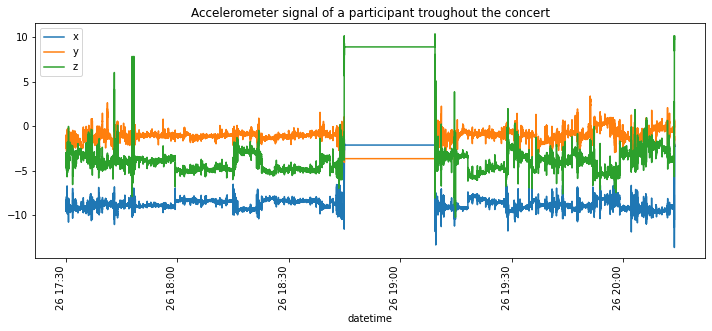

In [27]:
# devices
# dir_devices = DIR + 'Aligned/Hall/' # path to aligned accelerometer hall data
# list_devices = np.array(os.listdir(dir_devices))
# device_tags = [s.split('.')[0] for s in list_devices]

i = 4
participant = alignedParts.loc[i,:]

part = participant['Participant_Code']
if part[2]=='Q': # Motionlab phone acc
    inst_d = pd.read_csv(public_mlmotion + part + '_Mobile_Motion.csv' )
else: # AX3
    inst_d = pd.read_csv(public_ax3 + part + '_AX3_Motion.csv' )
inst_d['datetime']=(pd.to_datetime(inst_d['datetime'])) # concert time stamps, confirm format


inst_d.plot(x='datetime', y=['x','y','z'], figsize=(12,4.8), title='Accelerometer signal of a participant troughout the concert')
plt.xticks(rotation=90)
plt.show()

#device_tags, len(device_tags)

---
Start and end times indicate the first and the last claps heard in the concert hall. _'tag'_ is for explanations of clappings and used in file names. _clapping_type_ field indicates the relation of clappings, where _1_ indicates the clappings related to speeches or events occurred on the stage, _2_ is for the ones after pieces by Beethoven, Schnittke and Bach. _3_ is for the ones after the folk music pieces and _4_ indicates the final applause at the end of the concert.

In [28]:
concert_applause = concert_times.loc[concert_times['Event_Type']=='Applause',:]
# music preceding Claps 4, 6, 8, 10-15
concert_applause

Event  Time_s_Start  Time_ms_Start  \
Time_dt_Start                                                    
2021-10-26 17:36:32.760   Claps 1       -693.24      -693240.0   
2021-10-26 17:38:47.960   Claps 2       -558.04      -558040.0   
2021-10-26 17:48:34.440   Claps 3         28.44        28440.0   
2021-10-26 18:14:54.520   Claps 4       1608.52      1608520.0   
2021-10-26 18:21:28.680  Claps 5        2002.68      2002680.0   
2021-10-26 18:42:46.540   Claps 6       3280.54      3280540.0   
2021-10-26 19:11:25.900   Claps 7       4999.90      4999900.0   
2021-10-26 19:28:23.660   Claps 8       6017.66      6017660.0   
2021-10-26 19:40:43.040   Claps 9       6757.04      6757040.0   
2021-10-26 19:43:37.240  Claps 10       6931.24      6931240.0   
2021-10-26 19:47:33.900  Claps 11       7167.90      7167900.0   
2021-10-26 19:53:41.360  Claps 12       7535.36      7535360.0   
2021-10-26 19:57:12.240  Claps 13       7746.24      7746240.0   
2021-10-26 19:57:35.520  Claps 14       7769.52      7769520.0   
2021-10-26 20:02:06.240  Claps 15       8040.24      8040240.0   

                         Time_Stream_Start              Time_dt_End  \
Time_dt_Start                                                         
2021-10-26 17:36:32.760             946.00  2021-10-26 17:36:49.840   
2021-10-26 17:38:47.960            1081.20  2021-10-26 17:38:55.880   
2021-10-26 17:48:34.440            1667.68  2021-10-26 17:48:44.360   
2021-10-26 18:14:54.520            3247.76  2021-10-26 18:15:35.880   
2021-10-26 18:21:28.680            3641.92  2021-10-26 18:21:40.460   
2021-10-26 18:42:46.540            4919.78  2021-10-26 18:43:46.980   
2021-10-26 19:11:25.900            6639.14  2021-10-26 19:11:43.560   
2021-10-26 19:28:23.660            7656.90  2021-10-26 19:28:45.780   
2021-10-26 19:40:43.040            8396.28  2021-10-26 19:41:00.540   
2021-10-26 19:43:37.240            8570.48  2021-10-26 19:43:56.800   
2021-10-26 19:47:33.900            8807.14  2021-10-26 19:47:53.220   
2021-10-26 19:53:41.360            9174.60  2021-10-26 19:53:57.120   
2021-10-26 19:57:12.240            9385.48  2021-10-26 19:57:25.880   
2021-10-26 19:57:35.520            9408.76  2021-10-26 19:57:40.540   
2021-10-26 20:02:06.240            9679.48  2021-10-26 20:03:53.280   

                         Time_s_End  Time_ms_End  Time_Stream_End  sequence  \
Time_dt_Start                                                                 
2021-10-26 17:36:32.760     -676.16    -676160.0           963.08         0   
2021-10-26 17:38:47.960     -550.12    -550120.0          1089.12         2   
2021-10-26 17:48:34.440       38.36      38360.0          1677.60         5   
2021-10-26 18:14:54.520     1649.88    1649880.0          3289.12        10   
2021-10-26 18:21:28.680     2014.46    2014460.0          3653.70        13   
2021-10-26 18:42:46.540     3340.98    3340980.0          4980.22        17   
2021-10-26 19:11:25.900     5017.56    5017560.0          6656.80        20   
2021-10-26 19:28:23.660     6039.78    6039780.0          7679.02        24   
2021-10-26 19:40:43.040     6774.54    6774540.0          8413.78        29   
2021-10-26 19:43:37.240     6950.80    6950800.0          8590.04        31   
2021-10-26 19:47:33.900     7187.22    7187220.0          8826.46        34   
2021-10-26 19:53:41.360     7551.12    7551120.0          9190.36        37   
2021-10-26 19:57:12.240     7759.88    7759880.0          9399.12        40   
2021-10-26 19:57:35.520     7774.54    7774540.0          9413.78        42   
2021-10-26 20:02:06.240     8147.28    8147280.0          9786.52        45   

                         Event_Duration Event_Type  
Time_dt_Start                                       
2021-10-26 17:36:32.760           17.08   Applause  
2021-10-26 17:38:47.960            7.92   Applause  
2021-10-26 17:48:34.440            9.92   Applause  
2021-10-26 18:14:54.520           41.36   Applause  
2021-10-26 18:21:28.680           1

In [29]:
df_clappings = pd.DataFrame(columns = ['section_id','start_time_concert','start_time','end_time_concert','end_time','tag','clapping_type'])
tags = ['Concert begins','Clapping Between Speeches 1','Clapping After Introduction','Beethoven Applause','Musicians Return 1','Schnittke Applause','Musicians Return 2','Bach Applause','Folk Music 1 Applause','Folk Music 2 Applause','Folk Music 3 Applause','Folk Music 4 Applause','Folk Music 5 Applause','Clapping Between Speeches 2','Final Applause']
df_clappings['section_id'] = range(len(tags))
df_clappings['start_time_concert'] = concert_applause['Time_s_Start'].values
df_clappings['start_time'] = concert_applause['Time_Stream_Start'].values
df_clappings['end_time_concert'] = concert_applause['Time_s_End'].values
df_clappings['end_time'] = concert_applause['Time_Stream_End'].values
df_clappings['tag'] = tags
df_clappings['clapping_type'] = [1,1,1,2,1,2,1,2,3,3,3,3,3,1,4]
df_clappings

section_id  start_time_concert  start_time  end_time_concert  end_time  \
0            0             -693.24      946.00           -676.16    963.08   
1            1             -558.04     1081.20           -550.12   1089.12   
2            2               28.44     1667.68             38.36   1677.60   
3            3             1608.52     3247.76           1649.88   3289.12   
4            4             2002.68     3641.92           2014.46   3653.70   
5            5             3280.54     4919.78           3340.98   4980.22   
6            6             4999.90     6639.14           5017.56   6656.80   
7            7             6017.66     7656.90           6039.78   7679.02   
8            8             6757.04     8396.28           6774.54   8413.78   
9            9             6931.24     8570.48           6950.80   8590.04   
10          10             7167.90     8807.14           7187.22   8826.46   
11          11             7535.36     9174.60           7551.12   9190.36   
12          12             7746.24     9385.48           7759.88   9399.12   
13          13             7769.52     9408.76           7774.54   9413.78   
14          14             8040.24     9679.48           8147.28   9786.52   

                            tag  clapping_type  
0                Concert begins              1  
1   Clapping Between Speeches 1              1  
2   Clapping After Introduction              1  
3            Beethoven Applause              2  
4            Musicians Return 1              1  
5            Schnittke Applause              2  
6            Musicians Return 2              1  
7                 Bach Applause              2  
8         Folk Music 1 Applause              3  
9         Folk Music 2 Applause              3  
10        Folk Music 3 Applause              3  
11        Folk Music 4 Applause              3  
12        Folk Music 5 Applause              3  
13  Clapping Between Speeches 2              1  
14               Final Applause              4

# Create datasets for clapping sections

This section is to process the accelerometer data and create datasets for each clapping interval.


In [95]:
# Step one, import the motion data at 50 Hz

# gather the aligned recordings for the live performance. Combining AX3 and ML data!
aud_df = pd.DataFrame(index = ts_ct)
kept_dev = []
gap_t = 100

for i,participant in alignedParts.iterrows():
    part = participant['Participant_Code']
    if part[2]=='Q': # Motionlab phone acc
        inst_d = pd.read_csv(public_mlmotion + part + '_Mobile_Motion.csv' )
    else: # AX3
        inst_d = pd.read_csv(public_ax3 + part + '_AX3_Motion.csv' )
    inst_d['datetime']=(pd.to_datetime(inst_d['datetime'])) # concert time stamps, confirm format
    datas = gap_nans(inst_d,gap_t)
    #get concert time
    resampled = pd.DataFrame(index = ts_ct)
    cols = datas.columns
    for col in cols[1:]:
        f = interp1d(datas['time'], datas[col],fill_value='extrapolate')
        resampled[col] = f(ts_ct)
        
    # extract 1D accelerometer feature for easy comparison
    # and basic normalisation
    b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1)
    if part[2]=='Q':
        aud_df[part] = b
    else:
        aud_df[part] = b*8 # correction factor for AX3s. Approximate
#     if np.nanmedian(b)>0:
#         aud_df[part] = b/np.nanmedian(b)
#     else:
#         aud_df[part] = b/np.nanmean(b)
        
aud_df.index = dt_ct

In [96]:
full_motion_50hz_df = aud_df.copy()
full_motion_50hz_df.index = ts_ct


In [229]:
# Step two, cut and save these per segment.

# low pass filter
T = 10.0        # sample period
fs = 50.0       # Hz
cutoff = 12.5   # cutoff frequency of the filter # Hz
nyq = 0.5 * fs  # nyquist frequency
order = 2 
n = int(T * fs)

for ev_idx in df_clappings['section_id']:
    ev_in, ev_out, ev_type, ev_tag = df_clappings.loc[ev_idx, ['start_time_concert', 'end_time_concert', 'clapping_type', 'tag']]

    extend = EXTEND_WINDOW[ev_type]
    in_event_time = (ev_in - extend) * 10**3
    out_event_time = (ev_out + extend) * 10**3
#     ts_ev = pd.date_range(start=pd.to_datetime(0), end=pd.to_datetime(abs(out_event_time - in_event_time), unit='ms'), freq='20ms')

    print('section:', ev_tag, (in_event_time, out_event_time),len(df_seg))

#     df_section = pd.DataFrame(index = ts_ev,columns = aud_df.columns)
    
    df_seg = full_motion_50hz_df.loc[in_event_time:out_event_time]
    
    ts_ev = np.round(df_seg.index - df_seg.index[0]) # not in date time for now, just ms
    df_section = pd.DataFrame(index = ts_ev,columns = aud_df.columns)
    for dev_n in df_seg.columns:
        #print('   ', dev_n)
        df_clap = df_seg.loc[:,dev_n]
        data_raw = df_clap[~np.isnan(df_clap)]
        if data_raw.shape[0] > 10:
            data_filtered = butter_lowpass_filter(data_raw, cutoff, fs, order)
        else:
            #data_raw[f.split('.')[0]] = np.nan
            data_filtered = data_raw
        df_clap.loc[data_raw.index] = data_filtered
        # save clapping interval as df
        df_section[dev_n] = df_clap.values
    # save clapping section as csv file
    output_dir = DIR + '/'# + 'Concert_content/clapping_motion/'
    df_section.index = pd.to_datetime(df_section.index, unit='ms').strftime('%H:%M:%S.%f')
    df_section.index.name = 'index'
    df_section.to_csv(output_dir + ev_tag.lower().replace(' ','_') + '_motion.csv')



section: Concert begins (-698240.0, -671160.0) 6052
section: Clapping Between Speeches 1 (-563040.0, -545120.0000000001) 1354
section: Clapping After Introduction (23440.00000000005, 43359.9999999999) 896
section: Beethoven Applause (1603520.0000000002, 1654880.0) 996
section: Musicians Return 1 (1997680.0, 2019460.0) 2568
section: Schnittke Applause (3275540.0, 3345980.0000000005) 1089
section: Musicians Return 2 (4994900.000000001, 5022560.0) 3522
section: Bach Applause (6012660.0, 6044780.000000001) 1383
section: Folk Music 1 Applause (6752040.000000001, 6779540.000000001) 1606
section: Folk Music 2 Applause (6926240.0, 6955800.000000001) 1375
section: Folk Music 3 Applause (7162900.0, 7192219.999999999) 1478
section: Folk Music 4 Applause (7530360.000000001, 7556120.000000001) 1466
section: Folk Music 5 Applause (7741240.0, 7764880.000000001) 1288
section: Clapping Between Speeches 2 (7764520.0, 7779540.000000001) 1182
section: Final Applause (8035240.0, 8152280.000000001) 751


# Focus on individual claps 

For further analysis, we extracted the time and amplitude values of each clap using peak picking and thresholding. To pick the clapping peaks out of the signal, a RMS and standard deviation based threshold is applied to the signal. By manually testing different weights for rms and std, 1 and 0.8 are selected as they provided the best performance in distinguishing the clapping and noise peaks.

This section outputs `*_trimmed` and `*_peaks` files, which contain individual clapping intervals and selected peaks respectively.

In [230]:
path_clapping_motion = DIR + '/'#+ 'Concert_content/clapping_motion/'
list_files = os.listdir(path_clapping_motion)
list_files

['bach_applause_motion.csv',
 'beethoven_applause_motion.csv',
 'clapping_after_introduction_motion.csv',
 'clapping_between_speeches_1_motion.csv',
 'clapping_between_speeches_2_motion.csv',
 'clapping_peaks',
 'clapping_trimmed',
 'concert_begins_motion.csv',
 'final_applause_motion.csv',
 'folk_music_1_applause_motion.csv',
 'folk_music_2_applause_motion.csv',
 'folk_music_3_applause_motion.csv',
 'folk_music_4_applause_motion.csv',
 'folk_music_5_applause_motion.csv',
 'musicians_return_1_motion.csv',
 'musicians_return_2_motion.csv',
 'schnittke_applause_motion.csv']

### test threshold

In [233]:
f = list_files[3]
# read data
df_motion = pd.read_csv(path_clapping_motion + f, index_col=[0])
df_motion.index = pd.Series(np.arange(0,len(df_motion.index))*0.02)
df_ev = df_motion.copy()

# create csv files
df_trimmed = pd.DataFrame(index=df_ev.index)
df_peaks = pd.DataFrame(index=df_ev.index, columns=df_ev.columns)
df_rms = pd.DataFrame(columns=df_ev.columns)

thr_list = []


In [239]:
extend_ind = 5*fs
seg_len=len(df_motion)
print(peak_index_list)
peak_index_list=peak_index_list[peak_index_list>extend]
peak_index_list=peak_index_list[peak_index_list<seg_len-extend]

[ 89 109 122 137 154 166 178 192 202 215 232 243 255 277 293 306 323 342
 354 365 375 388 398 408 422 444 455 470 482 499 512 525 539 558 568 581
 592 602 613 624 637 658 669 679 692 707 717 727 742 753 777 791 808 822
 833 844]


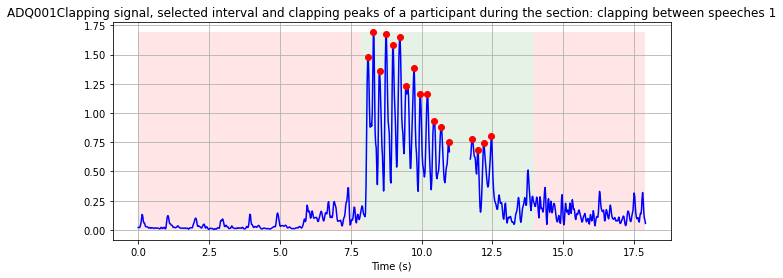

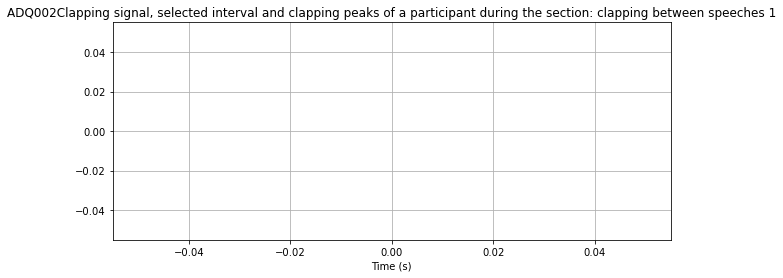

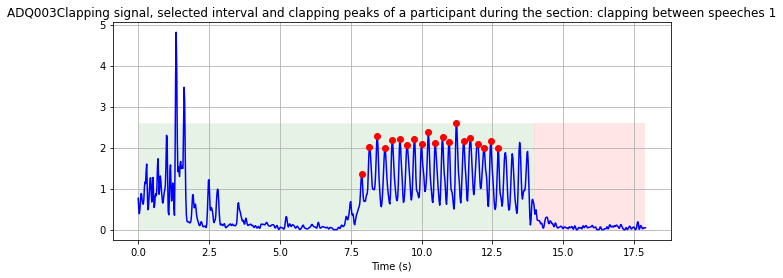

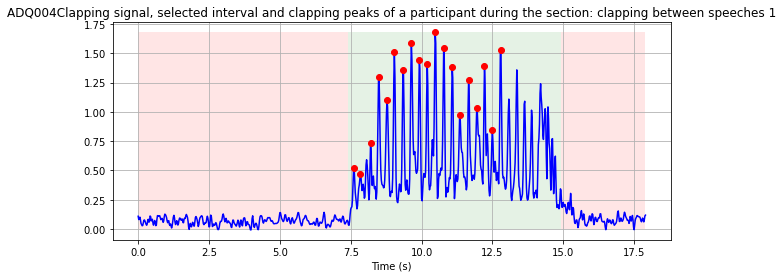

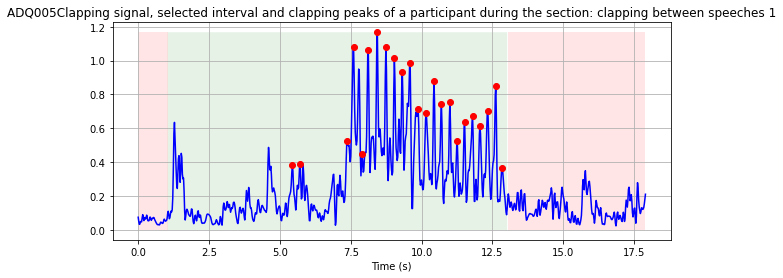

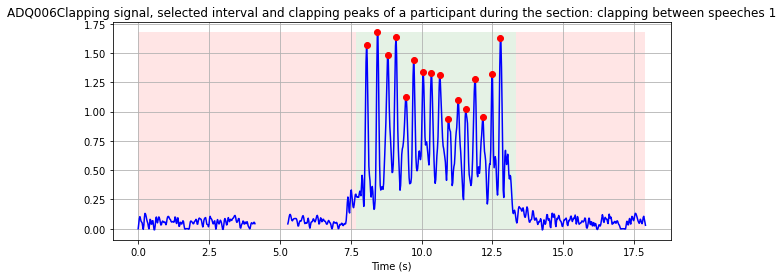

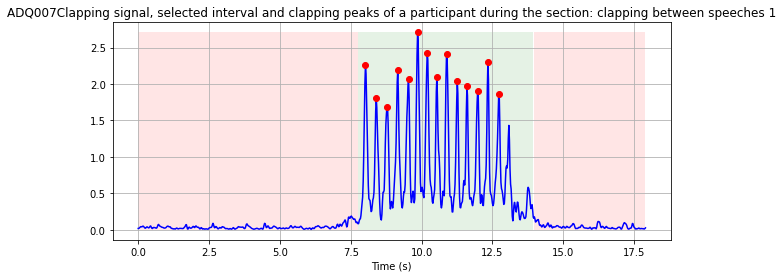

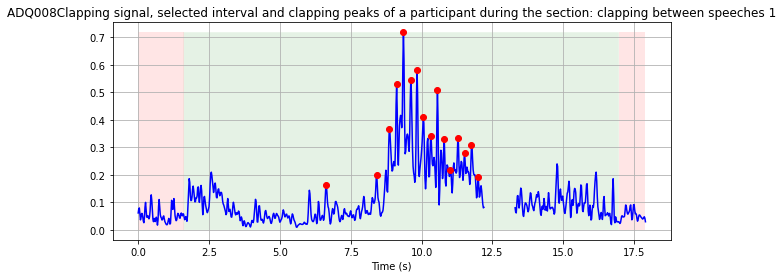

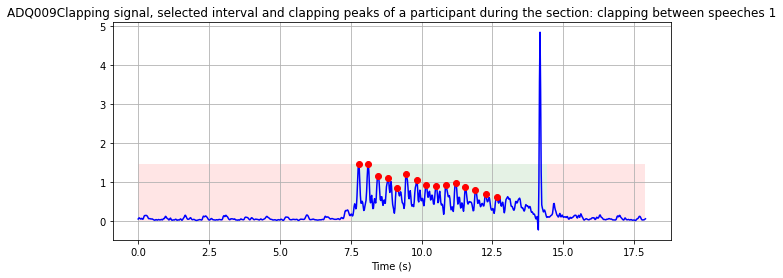

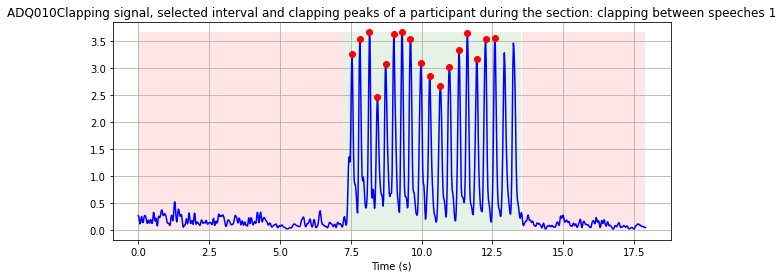

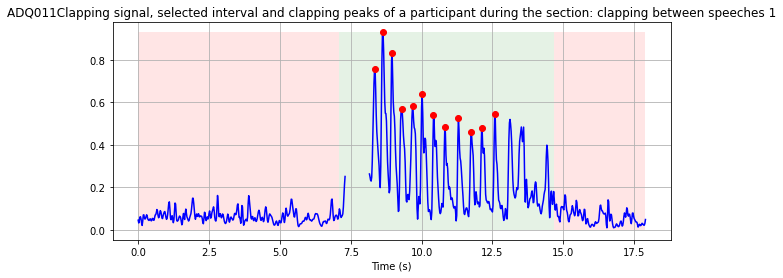

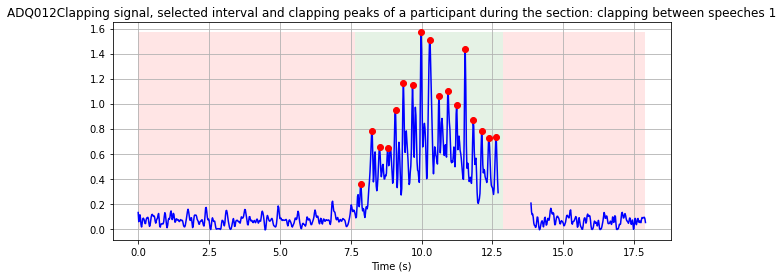

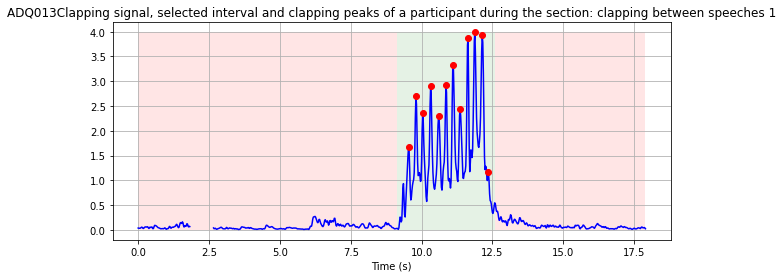

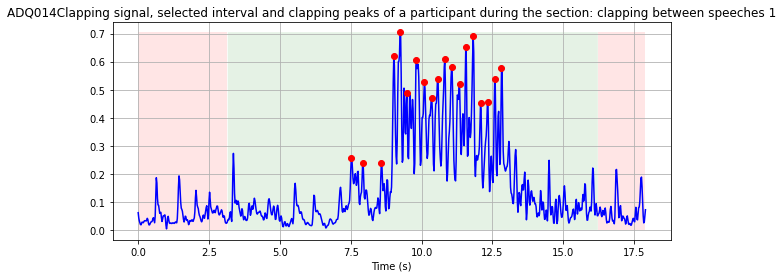

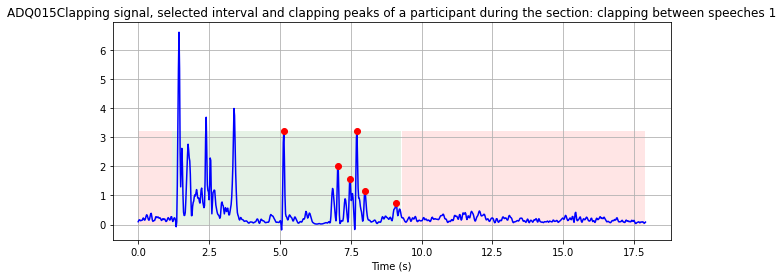

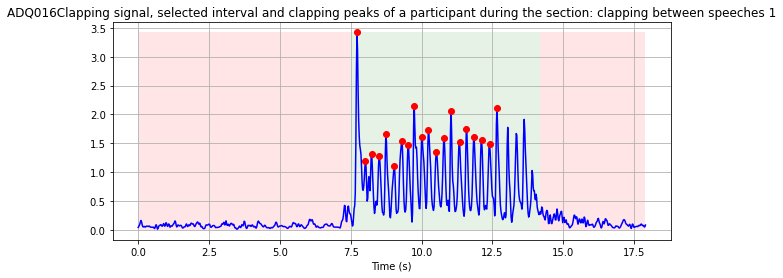

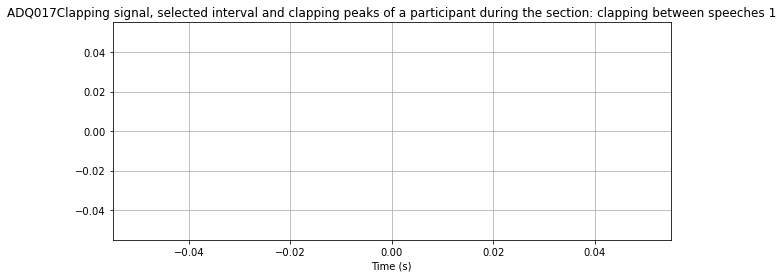

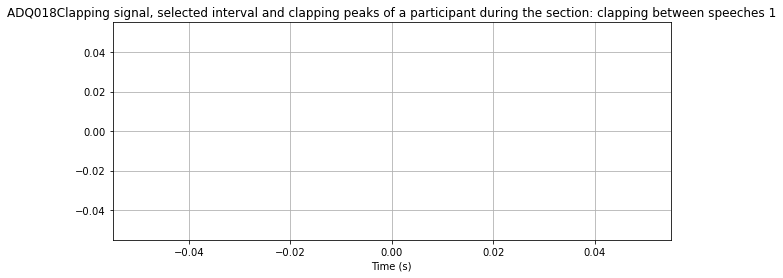

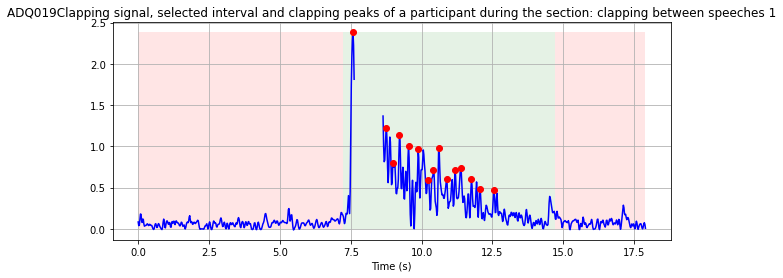

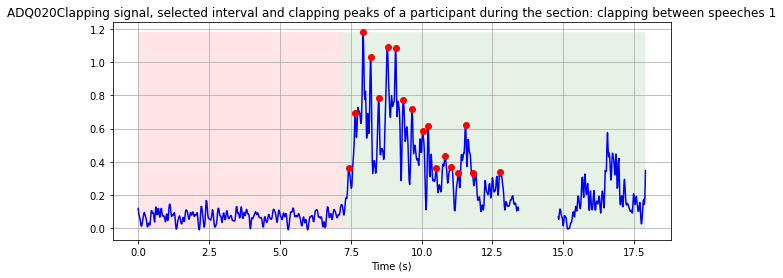

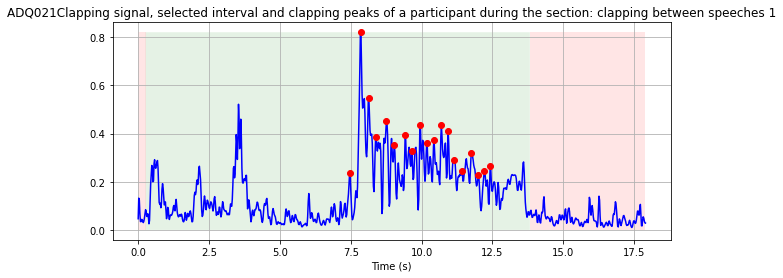

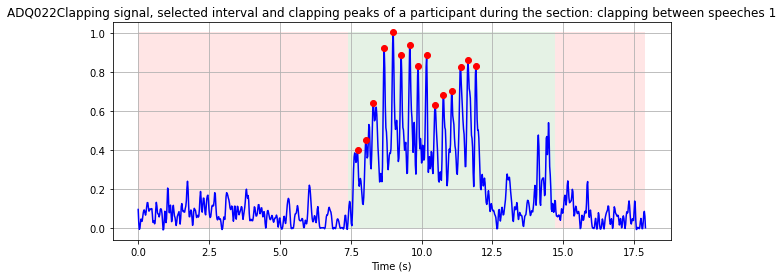

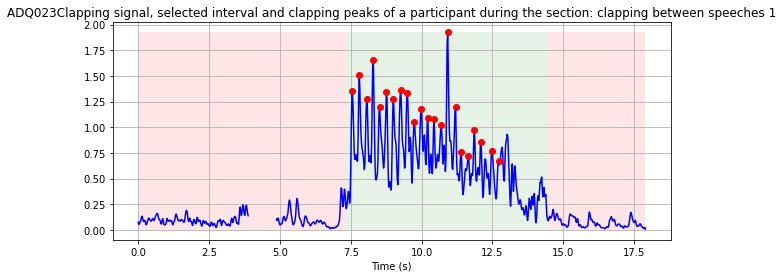

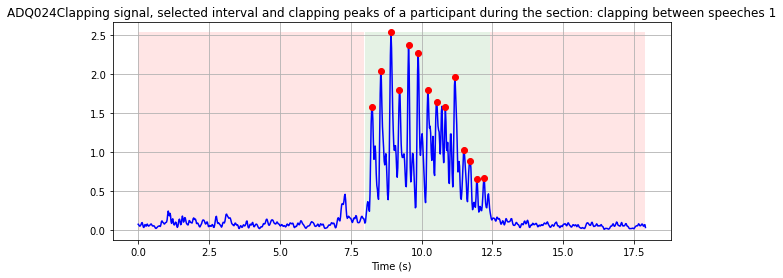

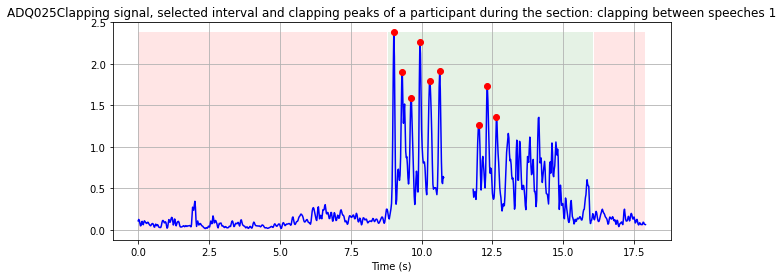

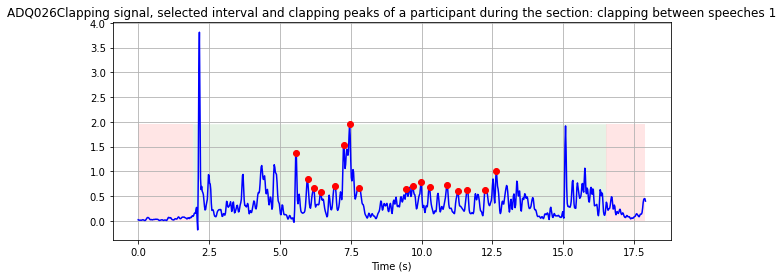

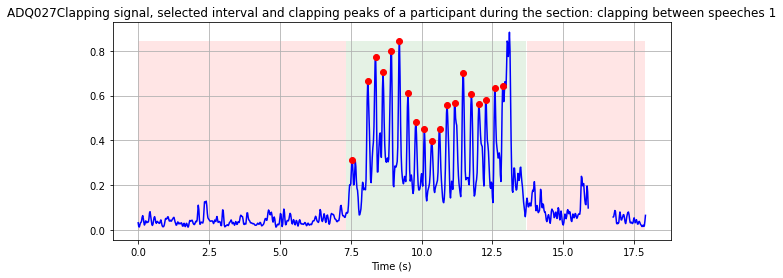

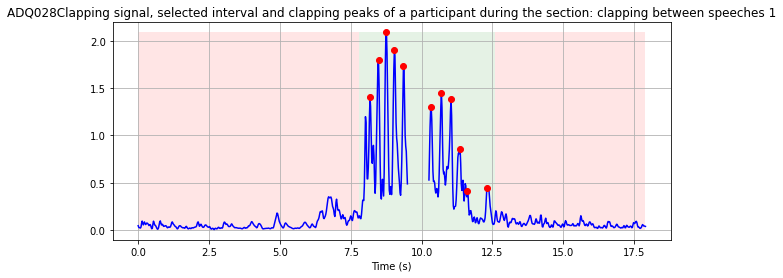

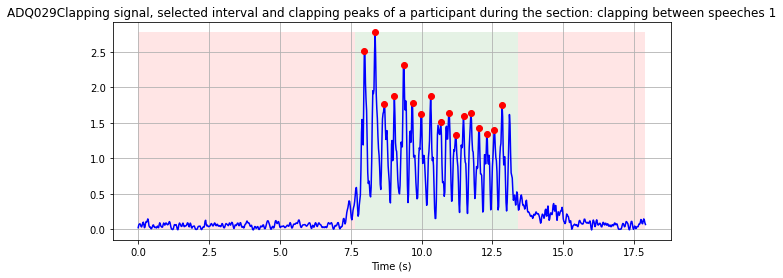

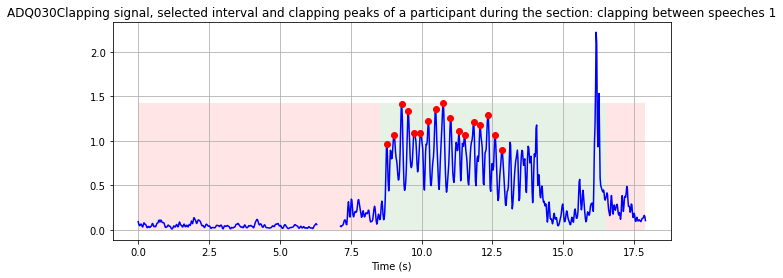

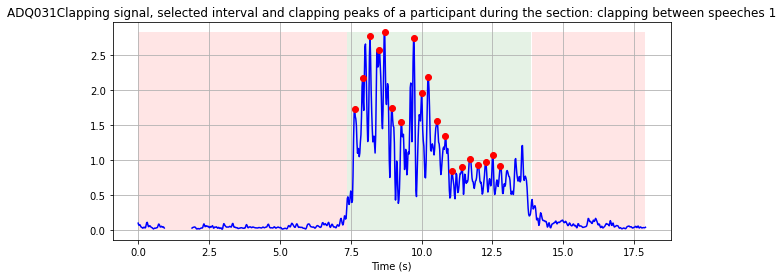

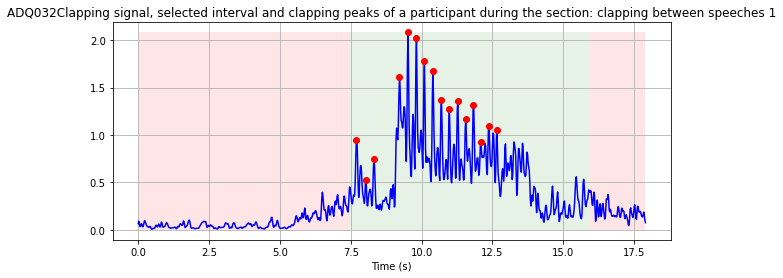

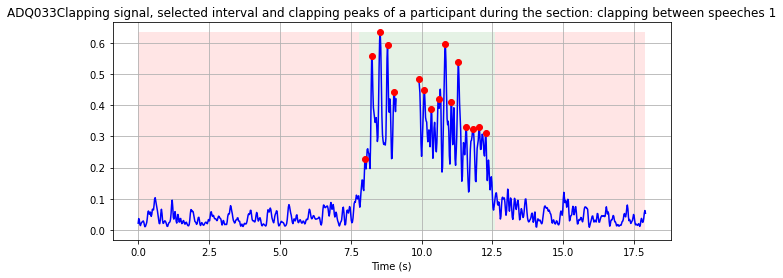

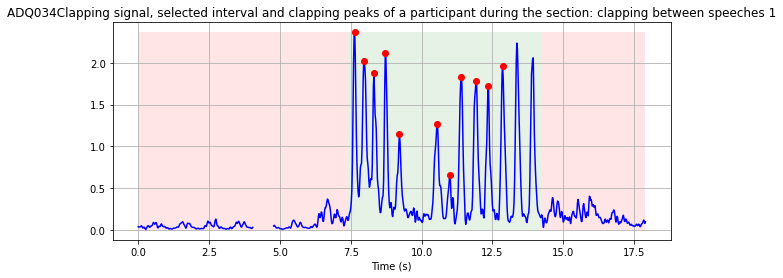

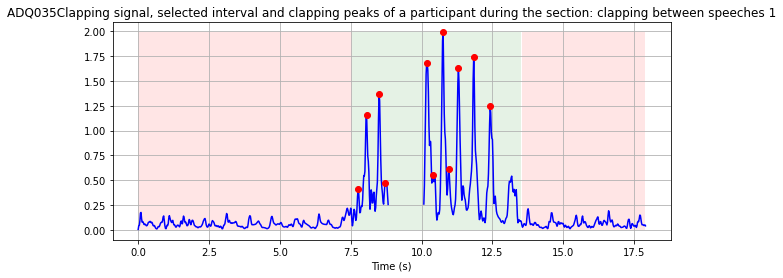

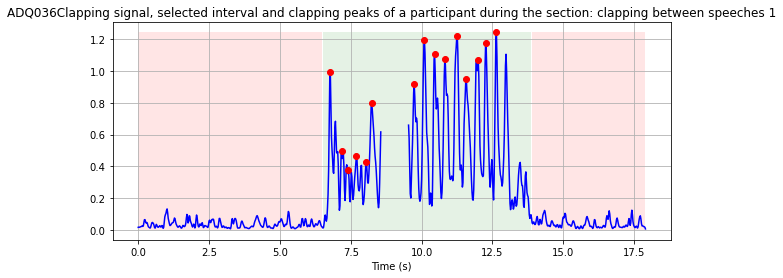

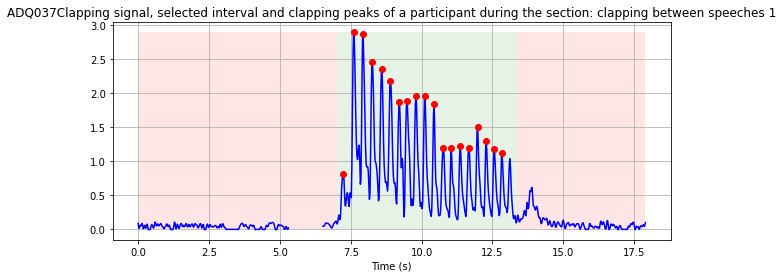

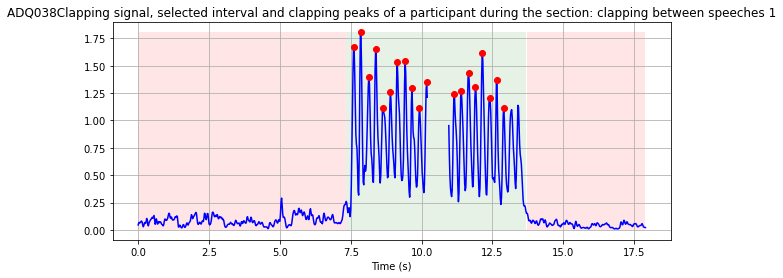

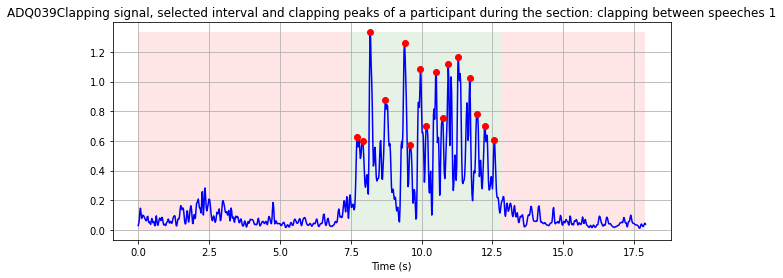

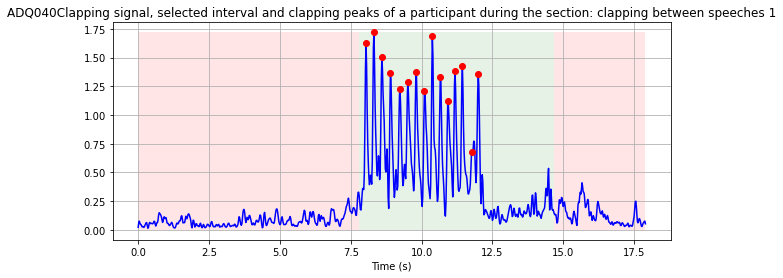

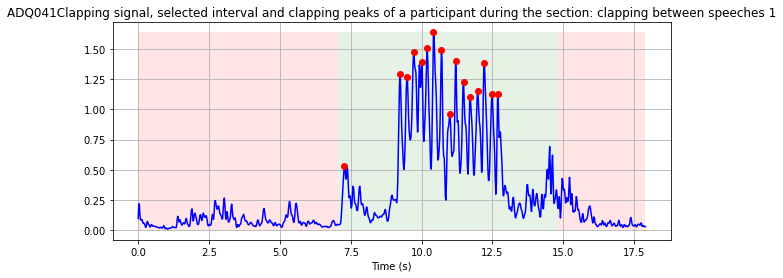

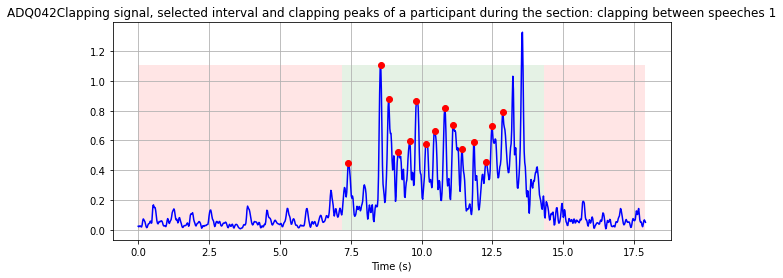

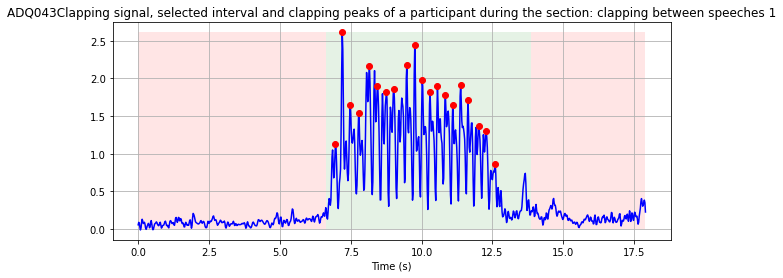

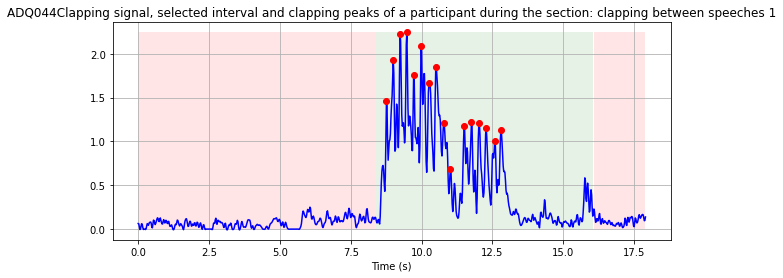

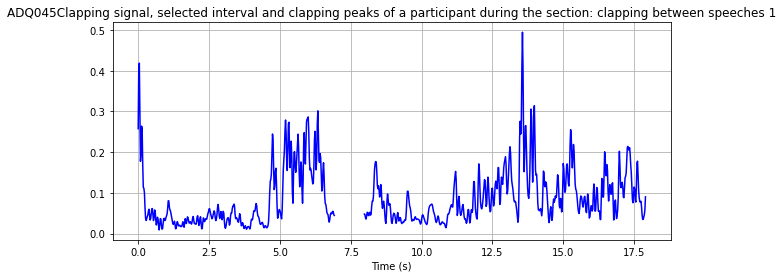

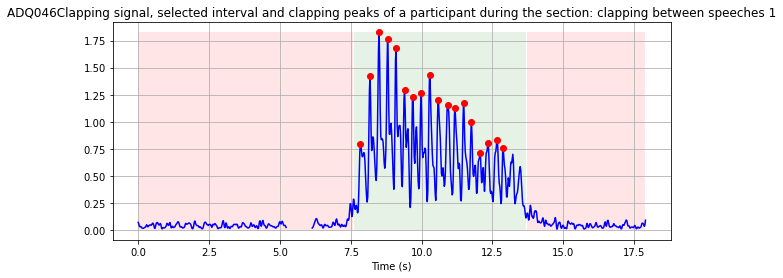

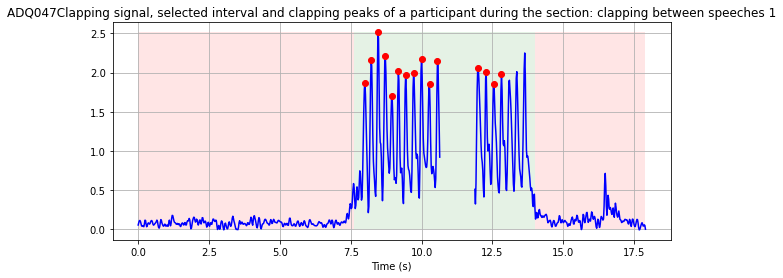

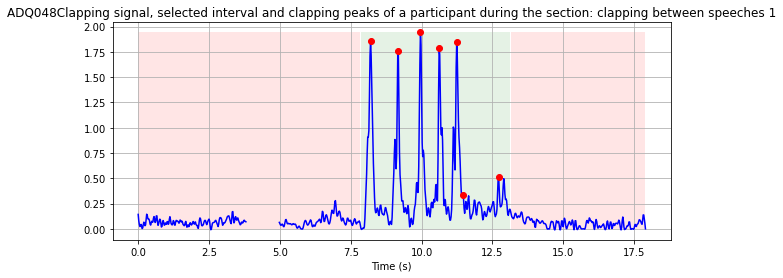

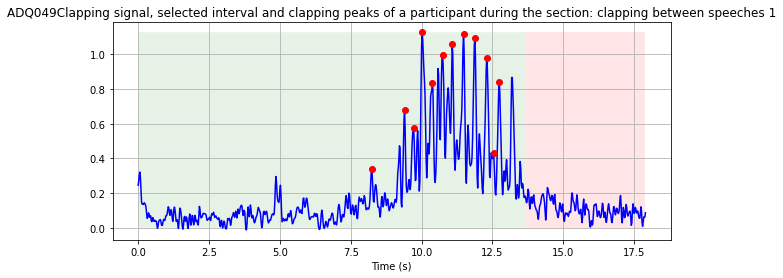

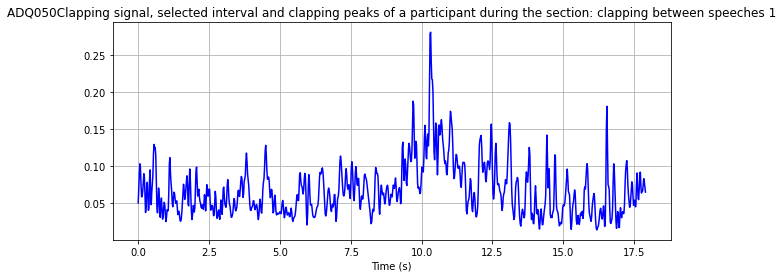

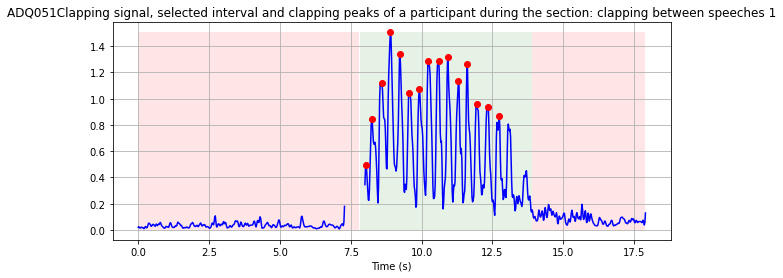

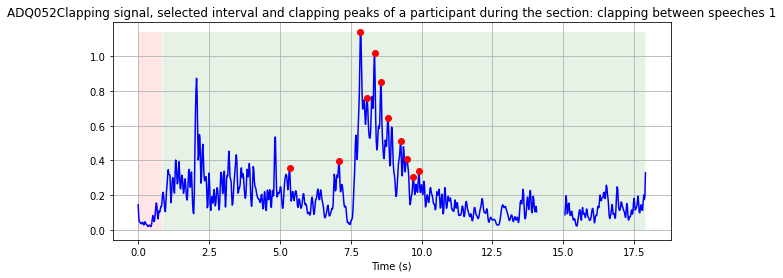

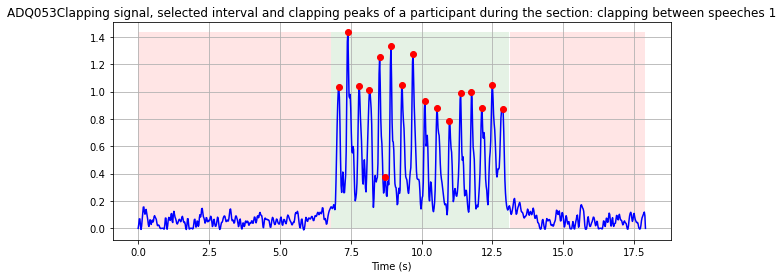

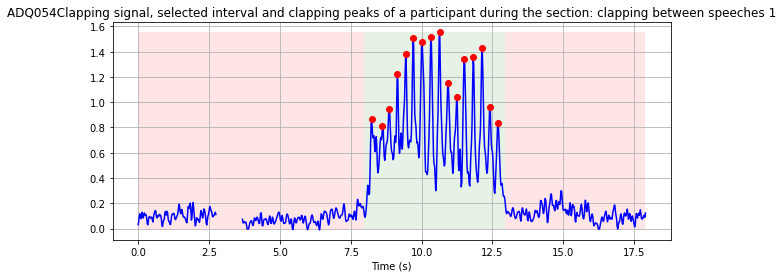

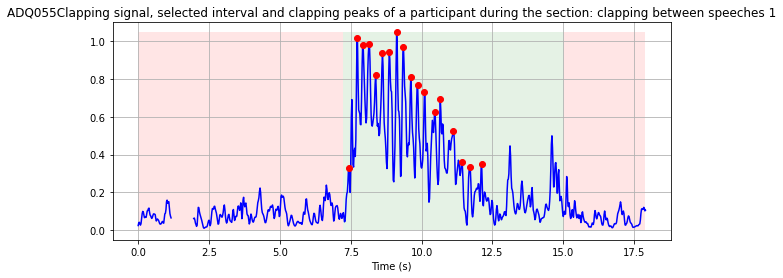

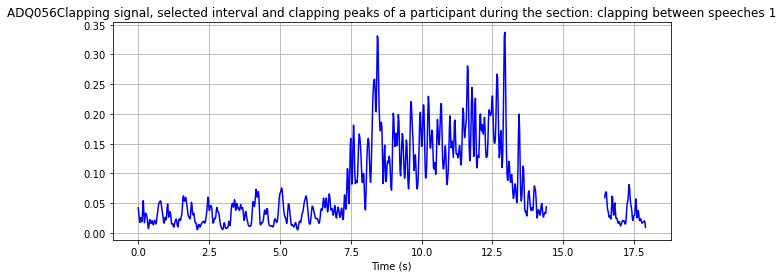

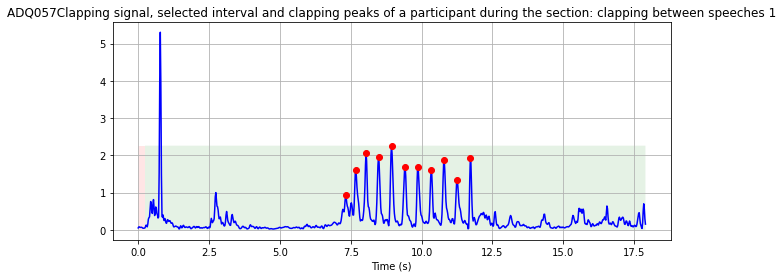

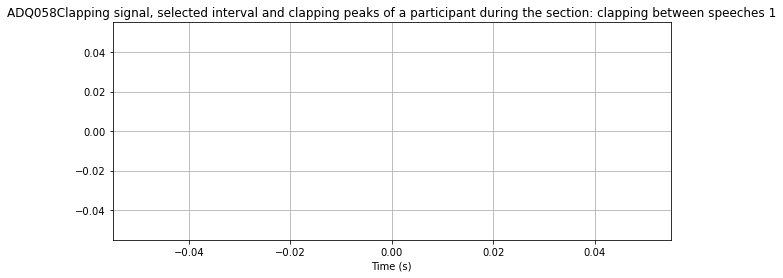

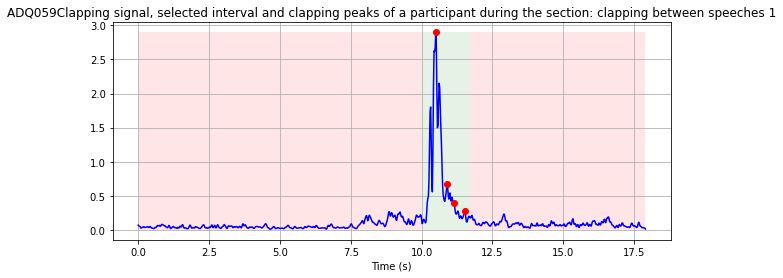

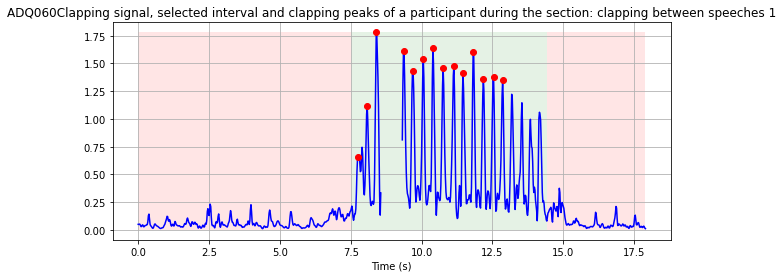

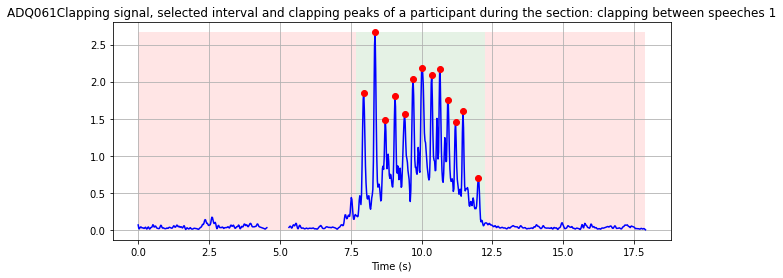

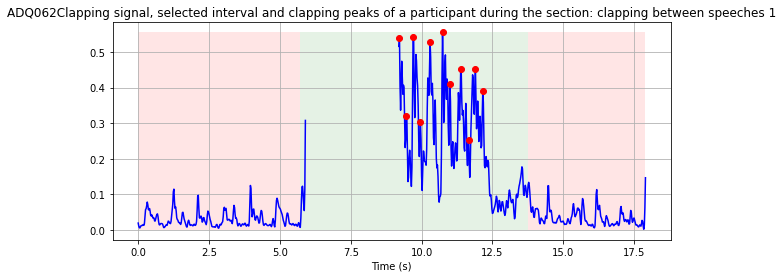

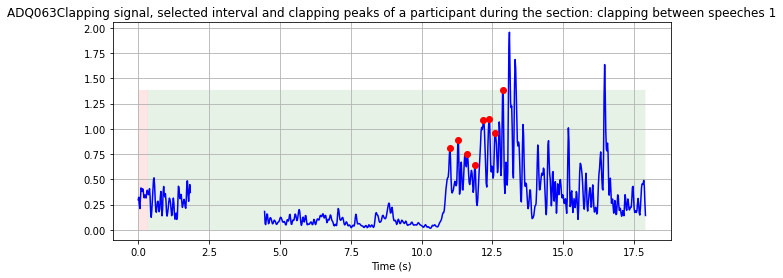

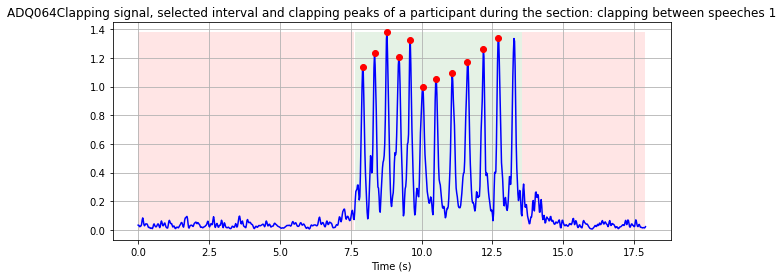

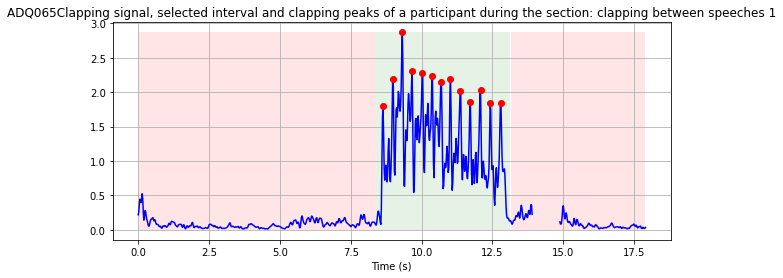

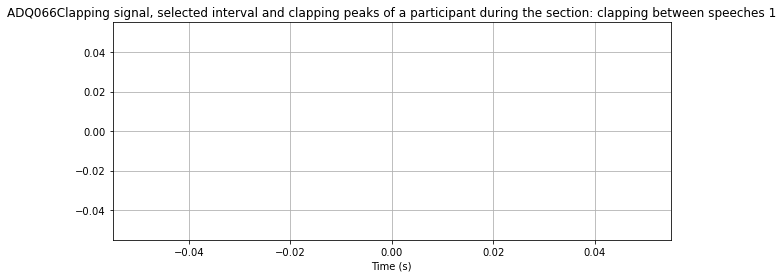

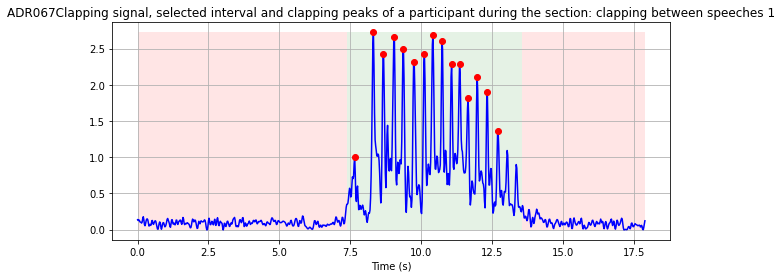

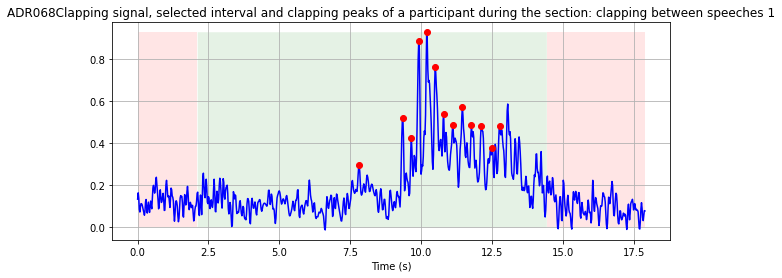

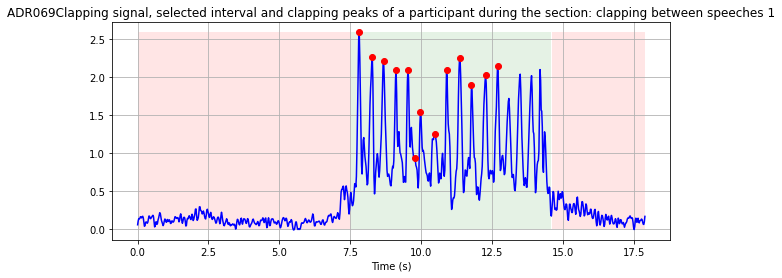

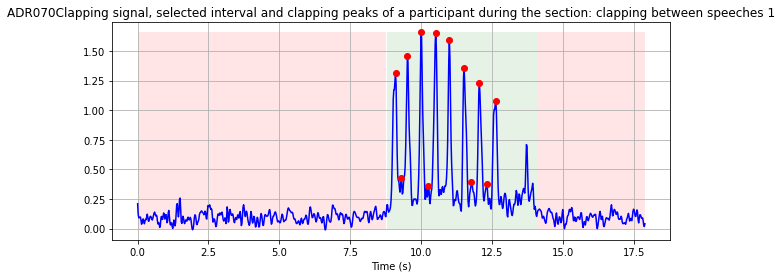

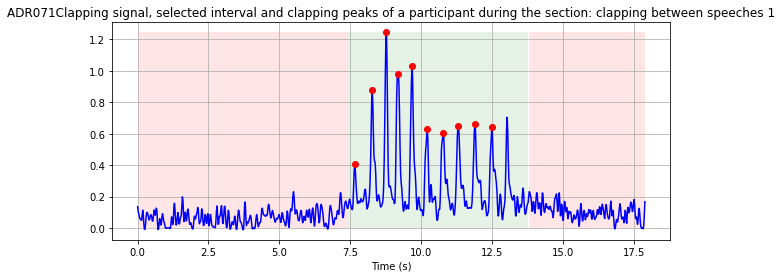

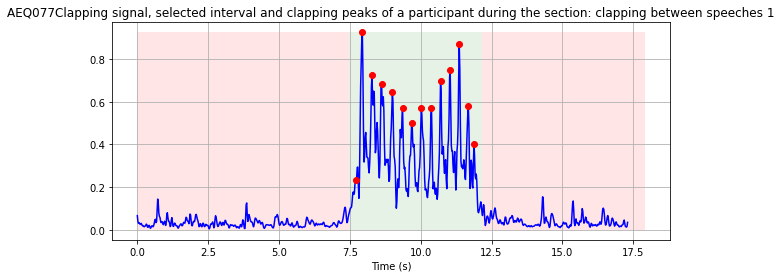

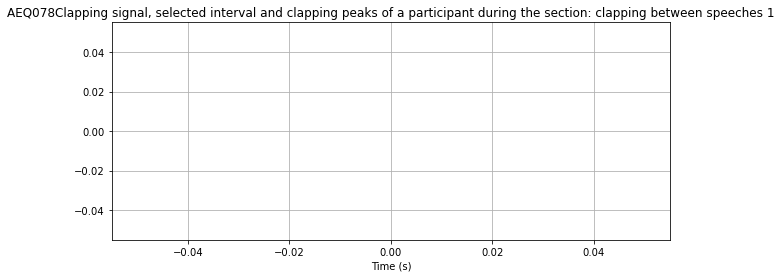

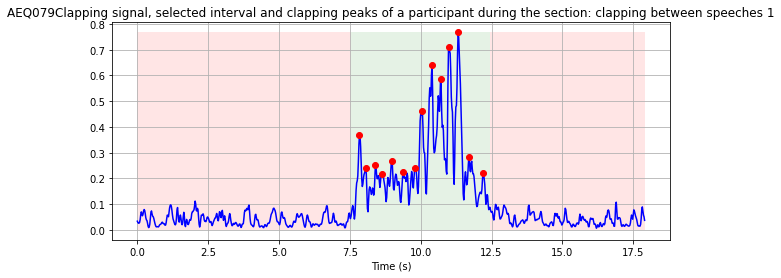

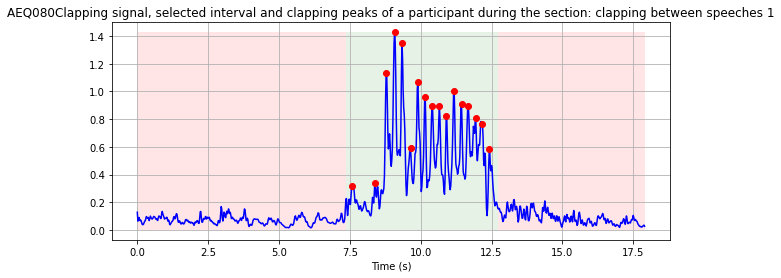

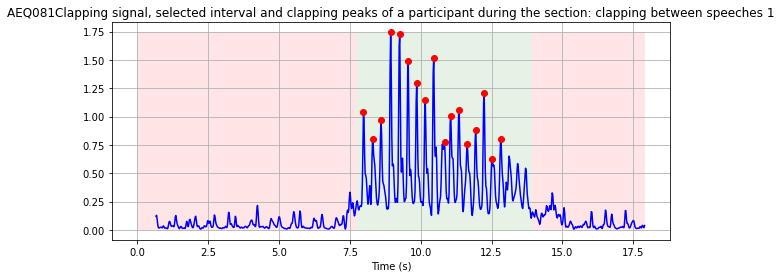

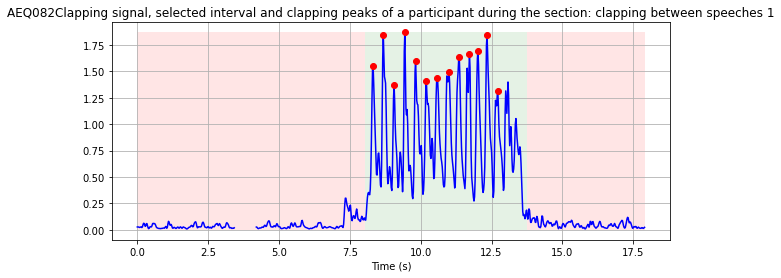

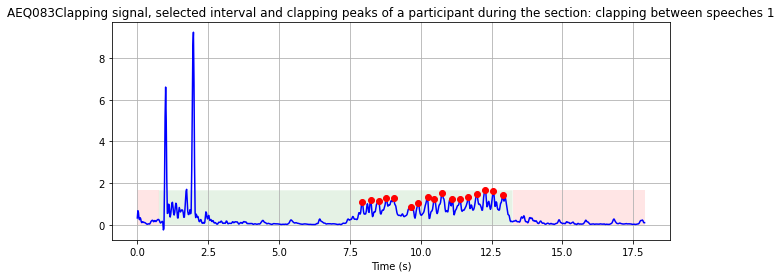

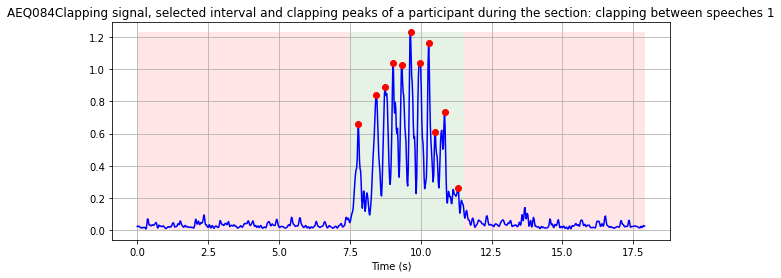

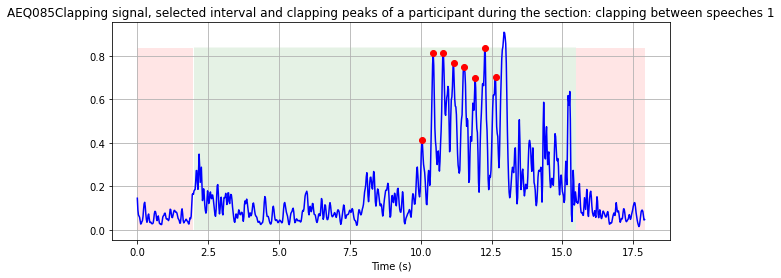

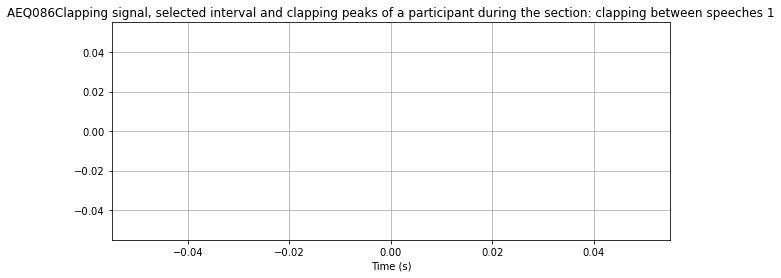

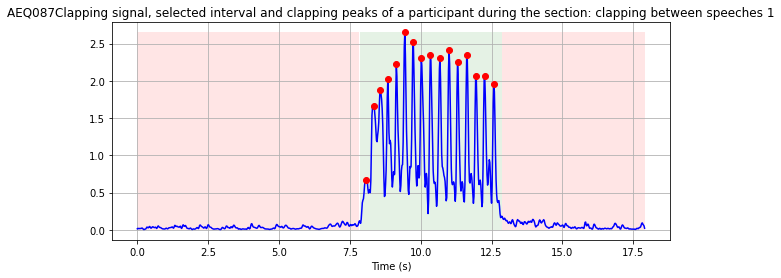

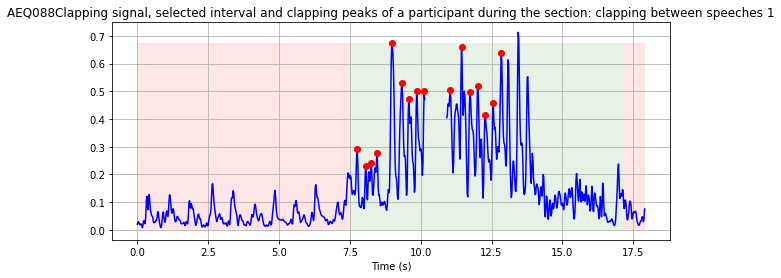

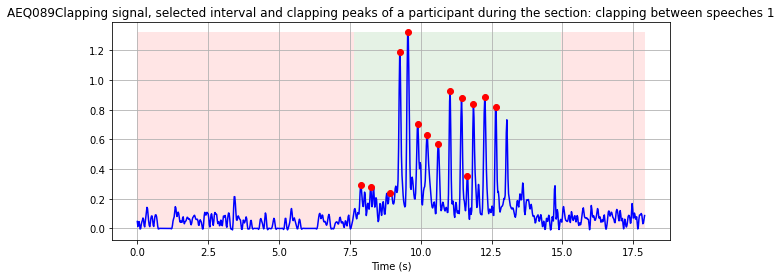

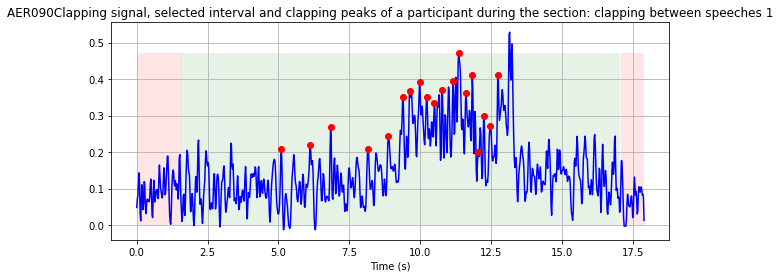

In [241]:
# read data
df_motion = pd.read_csv(path_clapping_motion + f, index_col=[0])
df_motion.index = pd.Series(np.arange(0,len(df_motion.index))*0.02)
df_ev = df_motion.copy()
extend_ind = 4*fs
seg_len=len(df_motion)

# create csv files
df_trimmed = pd.DataFrame(index=df_ev.index)
df_peaks = pd.DataFrame(index=df_ev.index, columns=df_ev.columns)
df_rms = pd.DataFrame(columns=df_ev.columns)

thr_list = []

for i, col in enumerate(df_ev.columns):
    rms = rms_signal(df_ev[col], SAMPLE_RATE, 4).dropna().replace(-1,np.nan)
    std = np.std(df_ev[col])
    thr = rms.mean()[0] + std*0.35
    thr = 0 if np.isnan(thr) else thr
    std_thr = 0.08
    # discard if std of signal is below std_thr
    thr = 0 if std<=std_thr else thr
    thr_list.append(thr)
    # save rms
    df_rms[col] = rms

    # in out pins
    # Extends the window 10 timestamps at both ends
    extend = 10 * 0.02
    if not (thr == 0):
        in_  = df_ev[df_ev[col]>thr][col].index.values[ 0] - extend
        out_ = df_ev[df_ev[col]>thr][col].index.values[-1] + extend
    else:
        in_  = 0
        out_ = 0
    df_ev.loc[:in_,col] = np.nan
    df_ev.loc[out_:,col] = np.nan

    # peaks
    peak_index_list = find_peaks(df_ev[col].values,distance=10)[0]
    # cut the peaks outside of the clapping range (not peaks because not audible in audio)
    peak_index_list=peak_index_list[peak_index_list>extend_ind]
    peak_index_list=peak_index_list[peak_index_list<seg_len-extend_ind]
    
    s_plot = df_ev[col].iloc[peak_index_list]
    s_plot = s_plot[s_plot>thr]

    # trim first and last peaks, + extend
    # Extends the window 10 timestamps at both ends after trimming the
    # signal based on first and last claps
    if not s_plot.notna().sum() == 0:
        if s_plot.notna().sum()/df_motion.index[-1] <4:
            in_peak = s_plot.dropna().iloc[:1].index.values[0] - extend
            out_peak = s_plot.dropna().iloc[-1:].index.values[0] + extend
            in_peak_dt = pd.to_datetime(in_peak).strftime('%H:%M:%S.%f')
            out_peak_dt = pd.to_datetime(out_peak).strftime('%H:%M:%S.%f')
            df_ev.loc[:in_peak,col] = np.nan
            df_ev.loc[out_peak:,col] = np.nan

    # write to df
    df_trimmed[col] = df_ev[col].values
    df_peaks.loc[:,col] = np.nan
    df_peaks.loc[s_plot.index,col] = s_plot.values
    
    #   # plot
    plt.figure(figsize = [10,4])
    i = -1 # participant idx
    plt.plot(df_motion.loc[:,col], 'b-', df_peaks.loc[:,col], 'ro')

    if df_peaks.loc[:,col].sum()>0:
        
        plt.fill_between(df_ev.index, df_peaks.loc[:,col].max(),
                       where=(df_trimmed.index>=in_)&(df_trimmed.index<=out_), fc='g', alpha=0.1)
        plt.fill_between(df_ev.index, df_peaks.loc[:,col].max(),
                       where=(df_trimmed.index<=in_)|(df_trimmed.index>=out_), fc='r', alpha=0.1)
        if thr == 0:
            plt.ylim(100)
            plt.axhline(thr_list[i], c='r', lw=2)
            plt.gcf().set_size_inches(24,4.8)

    plt.title(col + 'Clapping signal, selected interval and clapping peaks of a participant during the section: ' + ' '.join(f.split('_')[:-1]))
    plt.xlabel('Time (s)')
    plt.grid()
    plt.show()
        


In [219]:
df_motion.index[-1]

64.42

## generate peak files for each applause period

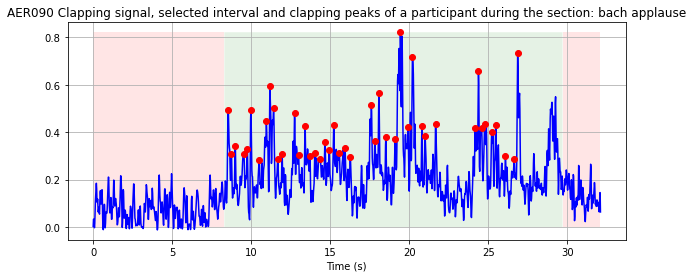

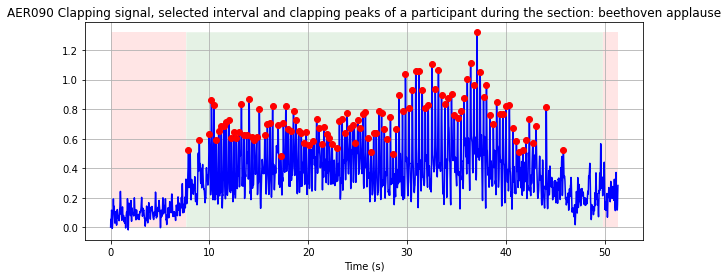

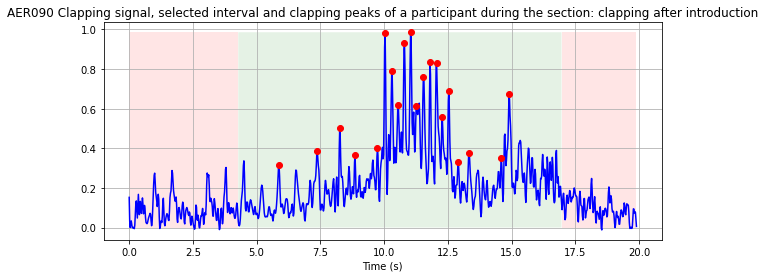

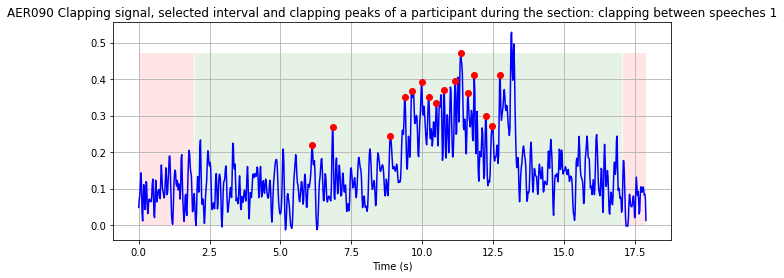

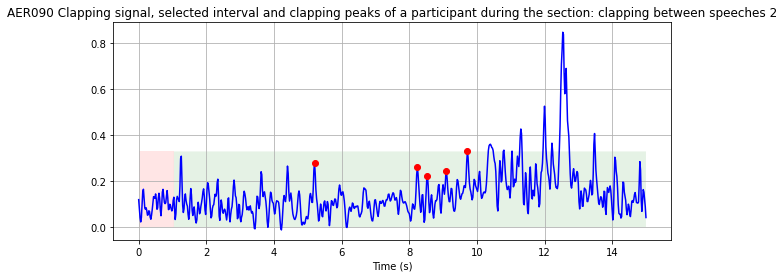

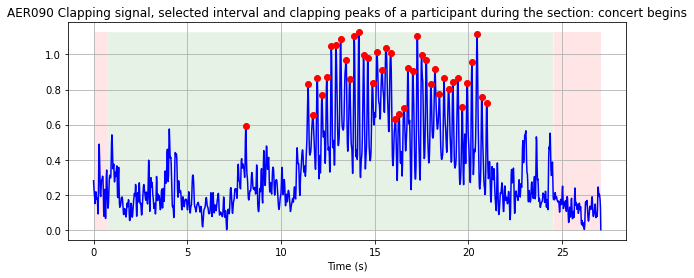

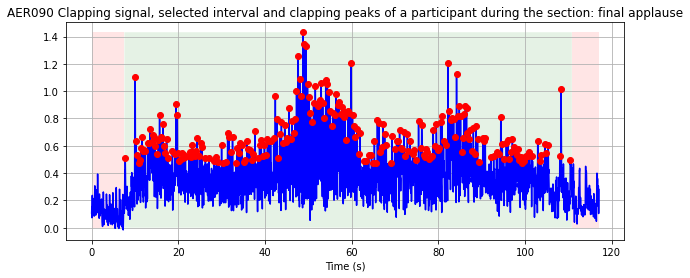

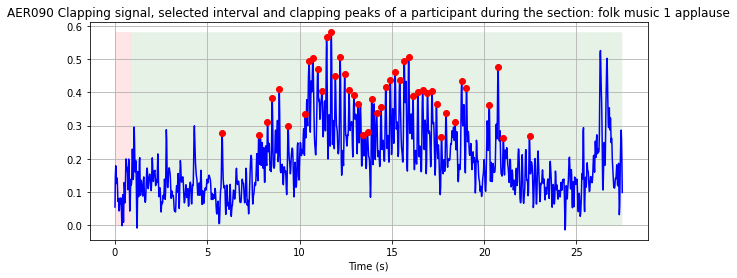

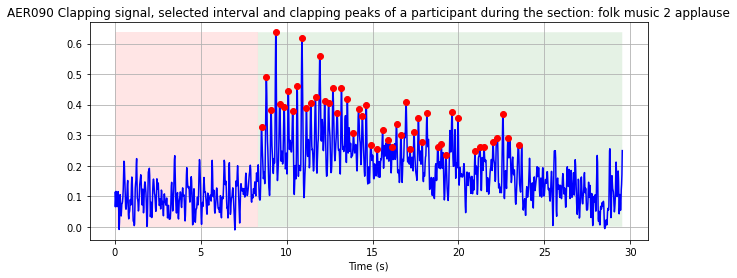

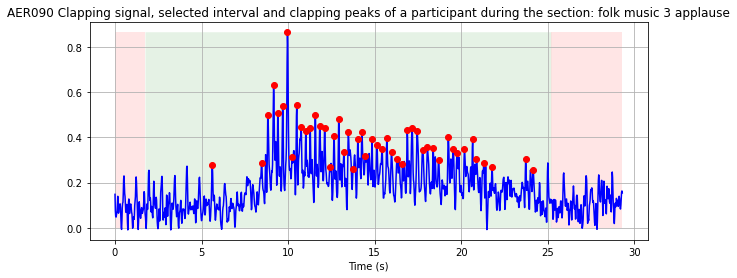

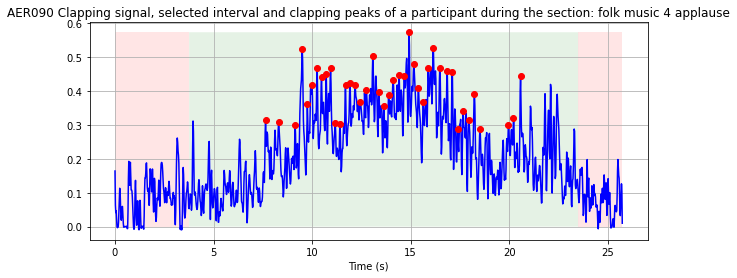

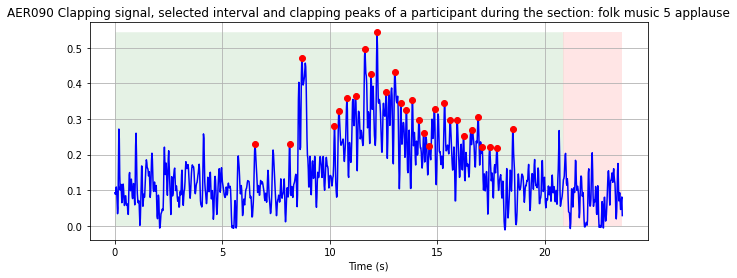

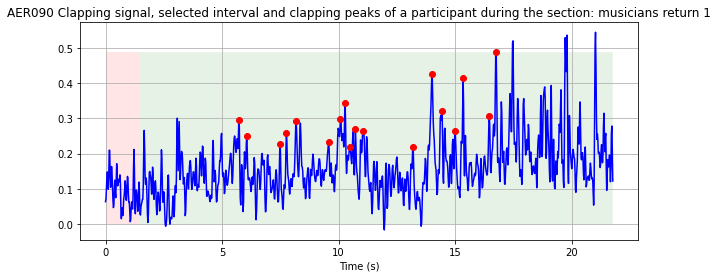

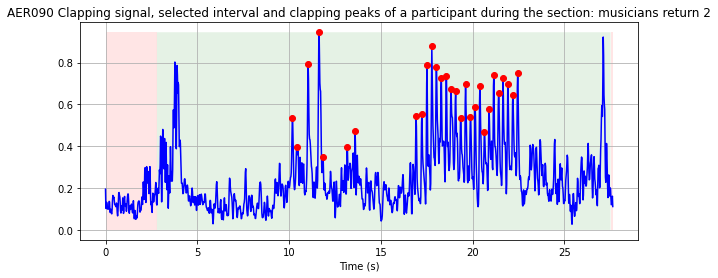

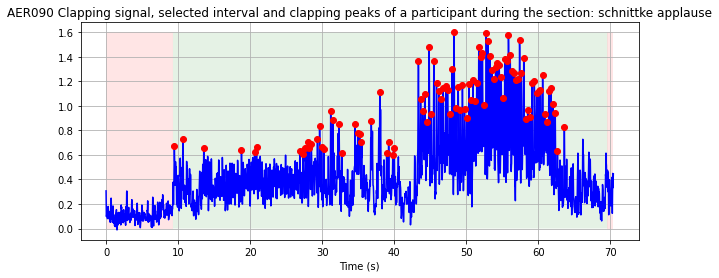

In [244]:
# for every clapping event
for f in list_files:
    # check if a csv file
    if not f.endswith('.csv'):
        continue

    # read data
    df_motion = pd.read_csv(path_clapping_motion + f, index_col=[0])
    df_motion.index = pd.Series(np.arange(0,len(df_motion.index))*0.02)
    df_ev = df_motion.copy()
    extend_ind = 5*fs
    seg_len=len(df_motion)


    # create csv files
    df_trimmed = pd.DataFrame(index=df_ev.index)
    df_peaks = pd.DataFrame(index=df_ev.index, columns=df_ev.columns)
    df_rms = pd.DataFrame(columns=df_ev.columns)

    thr_list = []

    # for every participant
    for i, col in enumerate(df_ev.columns):
        # thresholding
        rms = rms_signal(df_ev[col], SAMPLE_RATE, 4).dropna().replace(-1,np.nan)
        std = np.std(df_ev[col])
        thr = rms.mean()[0] + std*0.5
        thr = 0 if np.isnan(thr) else thr
        std_thr = 0.08
        # discard if std of signal is below std_thr
        thr = 0 if std<=std_thr else thr
        thr_list.append(thr)

        # save rms
        df_rms[col] = rms

        # in out pins
        # Extends the window 10 timestamps at both ends
        extend = 10 * 0.02
        if not (thr == 0):
            in_  = df_ev[df_ev[col]>thr][col].index.values[ 0] - extend
            out_ = df_ev[df_ev[col]>thr][col].index.values[-1] + extend
        else:
            in_  = 0
            out_ = 0
        df_ev.loc[:in_,col] = np.nan
        df_ev.loc[out_:,col] = np.nan

        # peaks
        peak_index_list = find_peaks(df_ev[col].values,distance=10)[0]
        
        # cut the peaks outside of the clapping range (not peaks because not audible in audio)
        peak_index_list=peak_index_list[peak_index_list>=extend_ind]
        peak_index_list=peak_index_list[peak_index_list<=seg_len-extend_ind]
        
        s_plot = df_ev[col].iloc[peak_index_list]
        s_plot = s_plot[s_plot>thr]

        # trim first and last peaks, + extend
        # Extends the window 10 timestamps at both ends after trimming the
        # signal based on first and last claps
        df_peaks.loc[:,col] = np.nan
        
        if not s_plot.notna().sum() == 0:
            if s_plot.notna().sum()/df_motion.index[-1]<4: # last catch on extrem noise. Clapping should never be so numerous
                in_peak = s_plot.dropna().iloc[:1].index.values[0] - extend
                out_peak = s_plot.dropna().iloc[-1:].index.values[0] + extend
                in_peak_dt = pd.to_datetime(in_peak).strftime('%H:%M:%S.%f')
                out_peak_dt = pd.to_datetime(out_peak).strftime('%H:%M:%S.%f')
                df_ev.loc[:in_peak,col] = np.nan
                df_ev.loc[out_peak:,col] = np.nan
                
                df_peaks.loc[s_plot.index,col] = s_plot.values

        # write to df
        df_trimmed[col] = df_ev[col].values
        

        # end devices loop

    # save as csv files
    csv_trimmed_output_dir = DIR + '/clapping_trimmed/'
    df_trimmed_save = df_trimmed.copy()
    df_trimmed_save.index.name = 'index'
    df_trimmed_save.index = pd.date_range(0, periods=len(df_trimmed_save.index), freq='20ms').strftime('%H:%M:%S.%f')
    df_trimmed_save.to_csv(csv_trimmed_output_dir + f.replace('motion', 'trimmed'))

    csv_peaks_output_dir = DIR + '/clapping_peaks/'
    df_peaks_save = df_peaks.copy()
    df_peaks_save.index.name = 'index'
    df_peaks_save.index = pd.date_range(0, periods=len(df_peaks_save.index), freq='20ms').strftime('%H:%M:%S.%f')
    df_peaks_save.to_csv(csv_peaks_output_dir + f.replace('motion', 'peaks'))

    #   # plot
    plt.figure(figsize = [10,4])
    i = -1 # participant idx
    plt.plot(df_motion.loc[:,col], 'b-', df_peaks.loc[:,col], 'ro')

    if df_peaks.loc[:,col].sum()>0:
        
        plt.fill_between(df_ev.index, df_peaks.loc[:,col].max(),
                       where=(df_trimmed.index>=in_)&(df_trimmed.index<=out_), fc='g', alpha=0.1)
        plt.fill_between(df_ev.index, df_peaks.loc[:,col].max(),
                       where=(df_trimmed.index<=in_)|(df_trimmed.index>=out_), fc='r', alpha=0.1)
        if thr == 0:
            plt.ylim(100)
            plt.axhline(thr_list[i], c='r', lw=2)
            plt.gcf().set_size_inches(24,4.8)

    plt.title(col + ' Clapping signal, selected interval and clapping peaks of a participant during the section: ' + ' '.join(f.split('_')[:-1]))
    plt.xlabel('Time (s)')
    plt.grid()
    plt.show()
  # end clappings loop

    csv_trimmed_output_dir, os.listdir(csv_trimmed_output_dir), csv_peaks_output_dir, os.listdir(csv_peaks_output_dir)

The choices of claps on this AX3 sensors are particularly unreliable. It would be good to revist the thresholding criteria, given that we aren't normalising by median difference any more.